In [1]:
import manifpy as manif
import numpy as np
import matplotlib.pyplot as plt
import toml
from motion_filters import SE3EKF, SE3ISEKF
import os
import h5py
plt.rcParams["figure.figsize"] = (14,10)

# Simulate Motion in 3D space

In [2]:
#simulation data
T0 = manif.SE3(np.array([0,0,0,1,0,0,0]))
perturb = manif.SE3Tangent().Random()#wrong initial condition
time_step = 1000
dt = 0.001

vf = np.array([1.0, 1.0, 1.0, np.pi, np.pi, np.pi])
noise_std = np.ones(6) * 0.1

measurements = [T0]
real_datas = [T0.coeffs()]
track_coeff = [T0.coeffs()]
T = T0 + perturb*0.1
outlier_level = 1000
velocity_datas = []
for t in range(time_step):
    constant_velocity = -4*vf/float(time_step)/float(time_step) * t * (t - time_step)
    if t%100==0 and t!=0:
        noise_level = outlier_level*noise_std
    else:
        noise_level = noise_std
        
    T = T + manif.SE3Tangent(constant_velocity*dt) 
    measurements.append(T + manif.SE3Tangent(np.random.randn(6)*noise_level))
    real_datas.append(measurements[-1].coeffs())
    track_coeff += [T.coeffs()]
    velocity_datas += [constant_velocity]
track_coeff = np.vstack(track_coeff)
real_datas = np.vstack(real_datas)
velocity_datas = np.vstack(velocity_datas)

In [3]:
path = os.path.join(os.getcwd(),"../../config/filter_param.toml")
ekf = SE3EKF(dt, [T0, manif.SE3Tangent(np.zeros(6))], path)
isekf = SE3ISEKF(dt, [T0, manif.SE3Tangent(np.zeros(6))], path)

sigma init  [1.0000e-04 1.0000e-04 1.0000e-04 9.8596e-06 9.8596e-06 9.8596e-06]
epsilon init  [1. 1. 1. 1. 1. 1.]
lambda1 init  1.0
lambda2 init  1.0
gamma2 init  1.0


In [4]:
ekf_filter_T = []
ekf_filter_v = []

isekf_filter_T = []
isekf_filter_v = []

for t in range(time_step):
    x, P = ekf.step(measurements[t])
    ekf_filter_T.append(x[0].coeffs())
    ekf_filter_v.append(x[1].coeffs())

    x, P = isekf.step(measurements[t])
    isekf_filter_T.append(x[0].coeffs())
    isekf_filter_v.append(x[1].coeffs()) 

ekf_filter_T = np.vstack(ekf_filter_T)
ekf_filter_v = np.vstack(ekf_filter_v)

isekf_filter_T = np.vstack(isekf_filter_T)
isekf_filter_v = np.vstack(isekf_filter_v)

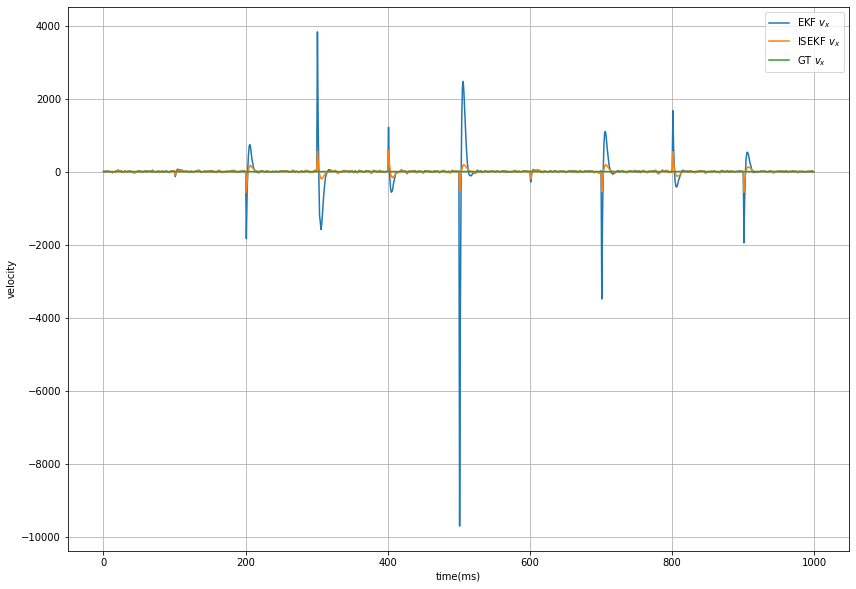

In [5]:
id = 0
lgs = ["$v_x$", "$v_y$", "$v_z$", "$w_x$", "$w_y$", "$w_z$"]

plt.plot(ekf_filter_v[:, id])
plt.plot(isekf_filter_v[:, id])
plt.plot(velocity_datas[:, id])
plt.legend(["EKF " + lgs[id], "ISEKF " + lgs[id], "GT " + lgs[id]])
plt.grid(True)
plt.ylabel("velocity")
plt.xlabel("time(ms)")
plt.savefig("velocity.jpg")
plt.show()

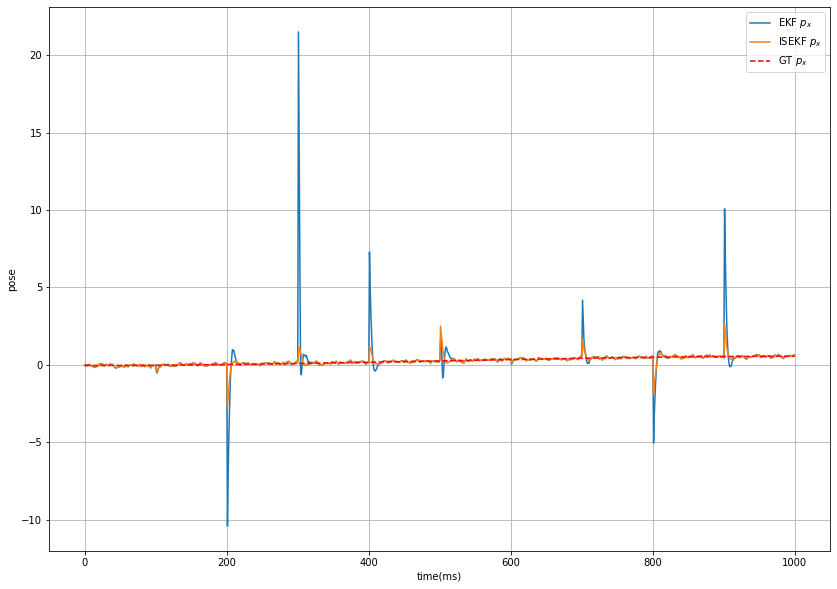

In [6]:
id = 0
lgs = ["$p_x$", "$p_y$", "$p_z$", "$quat_x$", "$quat_y$", "$quat_z$", "$quat_w$"]

plt.plot(ekf_filter_T[:, id],"-")
plt.plot(isekf_filter_T[:, id],"-")
plt.plot(track_coeff[:, id],"r--")
# plt.plot(real_datas[:, id], "x")
plt.grid(True)
plt.legend(["EKF " + lgs[id], "ISEKF " + lgs[id], "GT " + lgs[id]])

plt.ylabel("pose")
plt.xlabel("time(ms)")
plt.savefig("position.jpg")
plt.show()

# Real Data Test

In [62]:
dt = 0.01
step = int(1000*dt)
path = os.path.join(os.getcwd(),"../../config/filter_param.toml")
ekf = SE3EKF(dt, [T0, manif.SE3Tangent(np.zeros(6))], path)
isekf = SE3ISEKF(dt, [T0, manif.SE3Tangent(np.zeros(6))], path)

sigma init  [0.01       0.01       0.01       0.00098596 0.00098596 0.00098596]
epsilon init  [1. 1. 1. 1. 1. 1.]
lambda1 init  1.0
lambda2 init  1.0
gamma2 init  1.0


In [63]:
tracker_id = 3
h5f = h5py.File("../data/30_minutes.h5", "r")
raw_data = np.array(h5f[f"tracker{tracker_id}"]) # time, xyz q_wxyz
total_time = raw_data.shape[0]
max_time = total_time
min_time = 0


In [64]:
ekf_filter_T = []
ekf_filter_v = []

isekf_filter_T = []
isekf_filter_v = []

measurement = None
measurement_prev = None
finite_diff_v = []
for t in range(min_time, max_time, step):
    measurement = manif.SE3(raw_data[t])
    if t == min_time:
        ekf.T = measurement
        isekf.T = measurement
    else:
        x, P = ekf.step(measurement)
        ekf_filter_T.append(x[0].coeffs())
        ekf_filter_v.append(x[1].coeffs())

        x, P = isekf.step(measurement)
        # if t%1000==0:
        #     print(np.sqrt(isekf.sigma[0]))
        isekf_filter_T.append(x[0].coeffs())
        isekf_filter_v.append(x[1].coeffs())

        finite_diff_v.append((measurement-measurement_prev).coeffs()/dt)
    measurement_prev = measurement

ekf_filter_T = np.vstack(ekf_filter_T)
ekf_filter_v = np.vstack(ekf_filter_v)

isekf_filter_T = np.vstack(isekf_filter_T)
isekf_filter_v = np.vstack(isekf_filter_v)

finite_diff_v = np.vstack(finite_diff_v)

In [69]:
%matplotlib qt
id = 4
fig, axes = plt.subplots(2, 1)
lgs = ["$p_x$", "$p_y$", "$p_z$", "$quat_x$", "$quat_y$", "$quat_z$", "$quat_w$"]

axes[0].plot(ekf_filter_T[:, id],"--")
axes[0].plot(isekf_filter_T[:, id],"-", alpha=.8)
axes[0].plot(raw_data[min_time:max_time:step, id], marker='x', alpha=.5)
axes[0].grid(True)
axes[0].legend(["EKF " + lgs[id], "ISEKF " + lgs[id], "Raw " + lgs[id]])

axes[0].set_ylabel("pose")
axes[0].set_xlabel("time(ms)")
# axes[0].set_ylim([-2,2])
# plt.savefig("position.jpg")

lgs = ["$v_x$", "$v_y$", "$v_z$", "$w_x$", "$w_y$", "$w_z$"]

plt.plot(ekf_filter_v[:, id],"--")
plt.plot(isekf_filter_v[:, id],"-", alpha=.8)
axes[1].plot(finite_diff_v[:, id], marker='x', alpha=.5)
axes[1].legend(["EKF " + lgs[id], "ISEKF " + lgs[id], "FD " + lgs[id]])
axes[1].grid(True)
axes[1].set_ylabel("velocity")
axes[1].set_xlabel("time(ms)")

plt.show()

In [28]:
id = 0
lgs = ["$v_x$", "$v_y$", "$v_z$", "$w_x$", "$w_y$", "$w_z$"]

plt.plot(ekf_filter_v[:, id])
plt.plot(isekf_filter_v[:, id])
plt.plot(finite_diff_v[:, id])
plt.legend(["EKF " + lgs[id], "ISEKF " + lgs[id]])
plt.grid(True)
plt.ylabel("velocity")
plt.xlabel("time(ms)")
# plt.savefig("velocity.jpg")
plt.show()